In [5]:
import os
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
from ultralytics import YOLO
import matplotlib.pyplot as plt
import shutil
import subprocess
import matplotlib.pyplot as plt
from natsort import natsorted
import re
import matplotlib.pyplot as plt

## Tracking de cups

In [6]:
import cv2

from ultralytics import YOLO
from collections import defaultdict
import numpy as np

In [7]:
# Load the YOLO11 model
model = YOLO("yolo11s.pt")

In [8]:
def video_building(input_folder, output_video, fps):
    # === Paramètres ===
    frames_folder = input_folder   # Dossier contenant les images
    output_video = output_video    # Nom de la vidéo de sortie (ex. se terminant par .mp4)
    fps = fps                      # Images par seconde

    # === Récupère et trie les fichiers image ===
    images = [f for f in os.listdir(frames_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = natsorted(images)  # Pour garder l'ordre naturel : frame1, frame2, ...

    # === Lire la première image pour obtenir la taille ===
    first_image_path = os.path.join(frames_folder, images[0])
    frame = cv2.imread(first_image_path)
    if frame is None:
        raise ValueError(f"Impossible de lire la première image : {first_image_path}")
    
    # Unpack only the first two dimensions
    height, width = frame.shape[:2]

    # === Initialiser l’écrivain vidéo ===
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # ou 'XVID' pour AVI
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # === Ajouter les frames à la vidéo ===
    for image_name in images:
        image_path = os.path.join(frames_folder, image_name)
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Erreur de lecture de l'image : {image_path}")
            continue
        out.write(frame)

    out.release()
    print(f"Vidéo créée avec succès : {output_video}")

# Exemple d'utilisation
input_folder = "./TP3_data/frames"  # Dossier contenant les images
output_video = "default_dataset.mp4"  # Nom de la vidéo de sortie
fps = 30  # Images par seconde

video_building(input_folder, output_video, 30)

Vidéo créée avec succès : default_dataset.mp4


In [9]:
# Open the video file
video_path = output_video
cap = cv2.VideoCapture(video_path)

In [10]:
results = model.track(source=video_path,show=True,tracker="bytetrack.yaml",classes=[41])



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1385) c:\Users\war machine\Desktop\INF6804_LAB\TP3\default_dataset.mp4: 384x640 1 cup, 150.6ms
video 1/1 (frame 2/1385) c:\Users\war machine\Desktop\INF6804_LAB\TP3\default_dataset.mp4: 384x640 1 cup, 95.8ms
video 1/1 (frame 3/1385) c:\Users\war machine\Desktop\INF6804_LAB\TP3\default_dataset.mp4: 384x640 1 cup, 90.3ms
video 1/1 (frame 4/1385) c:\Users\war machine\Desktop\INF6804_LAB\TP3\default_dataset.mp4: 384x640 1 cup, 96.2ms
video

In [11]:
with open("results.txt", "w") as outfile:
    frame_idx = 1  # l'index de frame doit débuter à 1
    for result in results:
        if hasattr(result, "boxes") and result.boxes is not None:
            for box in result.boxes:
                # Récupérer les coordonnées sous le format [xmin, ymin, xmax, ymax]
                xyxy = box.xyxy.cpu().numpy()[0]
                xmin, ymin, xmax, ymax = map(int, xyxy)
                width = xmax - xmin
                height = ymax - ymin

                # Gestion de l'identifiant du suivi en vérifiant qu'il n'est pas None
                if hasattr(box, "id") and box.id is not None:
                    tracker_id = int(box.id)
                elif hasattr(box, "tracker_id") and box.tracker_id is not None:
                    tracker_id = int(box.tracker_id)
                else:
                    tracker_id = 0  # Valeur par défaut si aucun identifiant n'est disponible

                outfile.write(f"{frame_idx} {tracker_id} {xmin} {ymin} {width} {height}\n")
        frame_idx += 1

print("Le fichier results.txt a été créé avec succès.")

Le fichier results.txt a été créé avec succès.


## MOT17 DATASET

In [12]:

def extract_index(filename):
    # Extract the first group of digits from the filename
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group(0))
    return 0


class Track:
    def __init__(self, track_id, bbox):
        """Initialize a track with an ID and a bounding box [x1, y1, x2, y2]."""
        self.id = track_id
        self.bbox = bbox
        self.age = 0

    def update(self, new_bbox):
        self.bbox = new_bbox
        self.age = 0

    def predict(self):
        self.age += 1


def visualize_frames(frames_dir, num_frames=5):
    """Display the first few frames from the provided frames directory."""
    plt.figure(figsize=(15, 5))
    frame_files = list_frames(frames_dir)
    for i, filename in enumerate(frame_files[:num_frames]):
        path = os.path.join(frames_dir, filename)
        if os.path.exists(path):
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_frames, i+1)
            plt.imshow(img)
            plt.title(f'Frame {i+1}')
    plt.tight_layout()
    plt.show()


def load_tracks_from_gt(gt_file, init_frame=1):
    """
    Load initial tracks from the MOT17 ground truth file.
    MOT17 GT format (CSV): frame, id, bb_left, bb_top, bb_width, bb_height, ...
    Only tracks from the specified init_frame are loaded.
    """
    tracks = []
    with open(gt_file, 'r') as f:
        for line in f:
            parts = line.strip().split(",")
            frame_num = int(parts[0])
            if frame_num != init_frame:
                continue
            track_id = int(parts[1])
            x = int(float(parts[2]))
            y = int(float(parts[3]))
            w = int(float(parts[4]))
            h = int(float(parts[5]))
            tracks.append(Track(track_id, [x, y, x+w, y+h]))
    return tracks


def list_frames(frames_dir):
    """Return a sorted list of frame filenames (assumes they have a .jpg extension)."""
    frame_files = [f for f in os.listdir(frames_dir) if f.lower().endswith('.jpg')]
    return sorted(frame_files, key=extract_index)


def run_detection_on_frame(model, frame, class_id, conf_thresh=0.5):
    """
    Run YOLO detection on a frame and return detection boxes for the target class.
    Boxes are returned as [x1, y1, x2, y2].
    """
    results = model.predict(frame, conf=conf_thresh, classes=[class_id], verbose=False)
    detections = []
    if results and results[0].boxes is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            detections.append([x1, y1, x2, y2])
    return detections


def compute_iou(box_a, box_b):
    """Compute the Intersection over Union (IoU) between two bounding boxes."""
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    boxBArea = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    unionArea = boxAArea + boxBArea - interArea
    iou = interArea / unionArea if unionArea > 0 else 0
    return iou

def update_tracks(tracks, detections, iou_threshold):
    """
    Given current tracks and new detections, update the tracks using the Hungarian algorithm.
    New tracks are created for detections that do not match an existing track.
    """
    if not tracks:
        for d in detections:
            tracks.append(Track(1, d))
        return tracks

    iou_matrix = np.zeros((len(tracks), len(detections)))
    for t, track in enumerate(tracks):
        for d, det in enumerate(detections):
            iou_matrix[t, d] = compute_iou(track.bbox, det)

    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    matched_indices = set()
    for t, d in zip(row_ind, col_ind):
        if iou_matrix[t, d] >= iou_threshold:
            tracks[t].update(detections[d])
            matched_indices.add(d)

    for d in range(len(detections)):
        if d not in matched_indices:
            new_id = max([t.id for t in tracks], default=0) + 1
            tracks.append(Track(new_id, detections[d]))

    return tracks


def age_tracks(tracks, max_age):
    """Increase the age of each track and remove those that exceed max_age."""
    for track in tracks:
        track.predict()
    return [t for t in tracks if t.age <= max_age]


def process_frames(frames_dir, tracks, model, class_id, output_file, iou_threshold, max_age,
                   conf_thresh=0.5, use_detection_first_frame=True):
    """
    Process frames for detection and tracking, writing results to a file.
    Result format: frame track_id x y width height
    """
    frame_files = list_frames(frames_dir)
    with open(output_file, 'w') as results_file:
        for frame_num, frame_file in enumerate(frame_files, start=1):
            img_path = os.path.join(frames_dir, frame_file)
            frame = cv2.imread(img_path)
            if frame is None:
                continue

            if frame_num == 1 and not use_detection_first_frame:
                detections = []  # Use GT initialization (tracks already loaded)
            else:
                detections = run_detection_on_frame(model, frame, class_id, conf_thresh)

            tracks = update_tracks(tracks, detections, iou_threshold)
            tracks = age_tracks(tracks, max_age)

            for track in tracks:
                x1, y1, x2, y2 = track.bbox
                results_file.write(f"{frame_num} {track.id} {x1} {y1} {x2-x1} {y2-y1}\n")

            if frame_num % 50 == 0:
                print(f"Processing: {frame_num}/{len(frame_files)} frames")
    return frame_files


def load_tracking_results(results_file):
    """
    Load tracking results from a file (MOTChallenge format) into a dictionary keyed by frame.
    Expected line format: frame,id,x1,y1,w,h,conf,-1,-1,-1
    """
    tracking_results = {}
    with open(results_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 6:
                continue
            frame_id = int(parts[0])
            track_id = int(parts[1])
            x = float(parts[2])
            y = float(parts[3])
            w = float(parts[4])
            h = float(parts[5])
            tracking_results.setdefault(frame_id, []).append((track_id, x, y, w, h))
    return tracking_results


def create_output_video(frames_dir, frame_files, tracking_results, output_video, fps):
    """Overlay tracking results on each frame and write out a video file."""
    first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
    height, width, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for idx, frame_file in enumerate(frame_files, start=1):
        frame = cv2.imread(os.path.join(frames_dir, frame_file))
        if idx in tracking_results:
            for (track_id, x, y, w, h) in tracking_results[idx]:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, f"ID {track_id}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        video_writer.write(frame)

    video_writer.release()
    print("Video saved as", output_video)

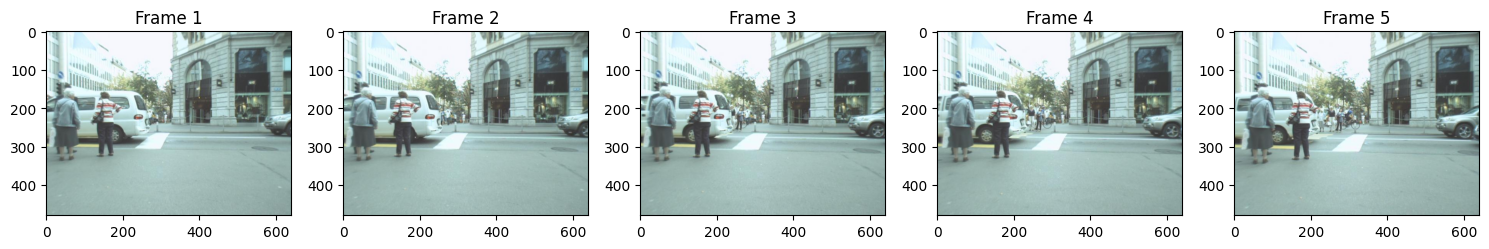

Processing: 50/837 frames
Processing: 100/837 frames
Processing: 150/837 frames
Processing: 200/837 frames
Processing: 250/837 frames
Processing: 300/837 frames
Processing: 350/837 frames
Processing: 400/837 frames
Processing: 450/837 frames
Processing: 500/837 frames
Processing: 550/837 frames
Processing: 600/837 frames
Processing: 650/837 frames
Processing: 700/837 frames
Processing: 750/837 frames
Processing: 800/837 frames
Video saved as result_video.avi


In [16]:


# Configuration for MOT17 Dataset (update these paths as needed)
FRAMES_DIR = './TP3_data/MOT17/MOT17/train/MOT17-05-FRCNN/img1'  # Adjust to your MOT17 sequence path
INIT_FILE = './TP3_data/MOT17/MOT17/train/MOT17-05-FRCNN/gt/gt.txt'    # Ground-truth file
OUTPUT_FILE = 'resultsMOT.txt'
IOU_THRESHOLD = 0.6
MAX_AGE = 5
CLASS_NAME = 'person'   # MOT17 mainly focuses on pedestrians
FPS = 20
OUTPUT_VIDEO = 'result_video.avi'

# Toggle the mode: set to True to run detection on ALL frames (recommended for continuous tracking).
# Set to False to use ground-truth initialization for frame 1 and detect on subsequent frames.
use_detection_first_frame = True

# Visualize initial frames
visualize_frames(FRAMES_DIR, num_frames=5)

# Load YOLO model (ensure this model can detect the target class)
model = YOLO('yolo11s.pt')
class_id = None
for k, v in model.names.items():
    if v.lower() == CLASS_NAME:
        class_id = k
        break
if class_id is None:
    raise ValueError(f"Class '{CLASS_NAME}' not found in the model")

# Initialize tracks
if not use_detection_first_frame:
    tracks = load_tracks_from_gt(INIT_FILE, init_frame=1)
else:
    tracks = []  # Detection initializes tracks from frame 1

# Process frames: run detection, tracking, and write results to a file
frame_files = process_frames(FRAMES_DIR, tracks, model, class_id, OUTPUT_FILE,
                              IOU_THRESHOLD, MAX_AGE, conf_thresh=0.5,
                              use_detection_first_frame=use_detection_first_frame)

# Load tracking results from the generated results file
tracking_results = load_tracking_results(OUTPUT_FILE)

# Create output video with tracking overlays
create_output_video(FRAMES_DIR, frame_files, tracking_results, OUTPUT_VIDEO, FPS)

In [17]:
def load_all_gt_data(gt_file, dataset_type='mot17'):
    """
    Load all ground truth boxes per frame from a GT file.
    For MOT17 (CSV): frame, id, bb_left, bb_top, bb_width, bb_height, ...
    Returns a dictionary:
      {frame_number: [(gt_id, [x1, y1, x2, y2]), ...], ...}
    """
    gt_data = {}
    with open(gt_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(",")
            frame_num = int(parts[0])
            gt_id = int(parts[1])
            x = int(float(parts[2]))
            y = int(float(parts[3]))
            w = int(float(parts[4]))
            h = int(float(parts[5]))
            box = [x, y, x + w, y + h]
            if frame_num in gt_data:
                gt_data[frame_num].append((gt_id, box))
            else:
                gt_data[frame_num] = [(gt_id, box)]
    return gt_data

def load_pred_data(results_file):
    """
    Load predicted boxes and track IDs per frame from the results file.
    Expected format: frame track_id x y width height
    Returns a dictionary:
      {frame_number: [(pred_id, [x1, y1, x2, y2]), ...], ...}
    """
    pred_data = {}
    with open(results_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            frame_num = int(parts[0])
            pred_id = int(parts[1])
            x = int(parts[2])
            y = int(parts[3])
            w = int(parts[4])
            h = int(parts[5])
            box = [x, y, x + w, y + h]
            if frame_num in pred_data:
                pred_data[frame_num].append((pred_id, box))
            else:
                pred_data[frame_num] = [(pred_id, box)]
    return pred_data

##############################################
# Compute Metrics per Frame
##############################################
def compute_metrics(gt_entries, pred_entries, iou_threshold):
    """
    Compute metrics for a single frame.
    Each entry is a tuple: (id, box) where box = [x1, y1, x2, y2].
    
    Returns:
        TP: Number of True Positives
        FP: Number of False Positives
        FN: Number of False Negatives
        iou_scores: List of IoU values for valid matches
        matches: List of (gt_id, pred_id) pairs for valid matches
    """
    iou_matrix = np.zeros((len(gt_entries), len(pred_entries)))
    for i, (_, gt_box) in enumerate(gt_entries):
        for j, (_, pred_box) in enumerate(pred_entries):
            iou_matrix[i, j] = compute_iou(gt_box, pred_box)
    
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    TP = 0
    FP = 0
    FN = 0
    iou_scores = []
    matched_gt = set()
    matched_pred = set()
    matches = []  # records (gt_id, pred_id)
    
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            TP += 1
            iou_scores.append(iou_matrix[i, j])
            matched_gt.add(i)
            matched_pred.add(j)
            matches.append((gt_entries[i][0], pred_entries[j][0]))
    FN = len(gt_entries) - len(matched_gt)
    FP = len(pred_entries) - len(matched_pred)
    
    return TP, FP, FN, iou_scores, matches

In [18]:

INIT_FILE = './TP3_data/MOT17/MOT17/train/MOT17-05-FRCNN/gt/gt.txt'
OUTPUT_FILE = 'resultsMOT.txt'
    
    # Load ground truth and prediction data
gt_data = load_all_gt_data(INIT_FILE, dataset_type='mot17')
pred_data = load_pred_data(OUTPUT_FILE)
    
# We'll assume that the frames present in the ground truth should be evaluated
frames = sorted(gt_data.keys())
    
# Initialize global counters and a dictionary for recording associations
total_TP = 0
total_FP = 0
total_FN = 0
iou_total = 0
nb_TP = 0
associations = {}  # key: gt_id, value: list of associated pred_ids
    
    # Process each frame and accumulate metrics
for frame in frames:
    gt_entries = gt_data.get(frame, [])
    pred_entries = pred_data.get(frame, [])
    TP, FP, FN, iou_scores, matches = compute_metrics(gt_entries, pred_entries, iou_threshold=0.5)
    total_TP += TP
    total_FP += FP
    total_FN += FN
    iou_total += sum(iou_scores)
    nb_TP += len(iou_scores)
        
    # Record each valid match for association computation
    for (gt_id, pred_id) in matches:
        if gt_id in associations:
            associations[gt_id].append(pred_id)
        else:
            associations[gt_id] = [pred_id]
    
    # Compute Detection Accuracy and Localization Accuracy
DetA = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
LocA = (iou_total / nb_TP) if nb_TP > 0 else 0
    
    # Compute dynamic Association Accuracy (AssA)
assoc_scores = []
for gt_id, pred_id_list in associations.items():
    n = len(pred_id_list)
    if n <= 1:
        score = 1.0  # Only one match; assume perfect association.
    else:
        total_pairs = n * (n - 1) / 2
        consistent_pairs = 0
        for i in range(n):
            for j in range(i + 1, n):
                if pred_id_list[i] == pred_id_list[j]:
                    consistent_pairs += 1
        score = consistent_pairs / total_pairs
    assoc_scores.append(score)
AssA = np.mean(assoc_scores) if assoc_scores else 0
    
    # Compute HOTA using two formulas:
    # HOTA: Geometric mean of the three components
    # HOTA_all: Arithmetic mean of the three components
HOTA = (DetA * LocA * AssA) ** (1/3) if (DetA * LocA * AssA) > 0 else 0
HOTA_all = (DetA + LocA + AssA) / 3
    
    # Print metrics
print("HOTA (geometric mean) =", HOTA)
print("DetA =", DetA)
print("AssA =", AssA)
print("LocA =", LocA)
print("HOTA_all (arithmetic mean) =", HOTA_all)
    
    # For HOTA(0): You can similarly redo the matching with a lower iou_threshold (e.g., 0.05)
    # and compute the metrics accordingly.

HOTA (geometric mean) = 0.5690834518007585
DetA = 0.4444981628311739
AssA = 0.543779794793147
LocA = 0.7624911975975153
HOTA_all (arithmetic mean) = 0.5835897184072788
